In [1]:
# Temporary import. It will be removed in the final vserion
import os
import sys

import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from pytagi import exponential_scheduler
from pytagi.nn import LSTM, Linear, Sequential

from examples.data_loader import TimeSeriesDataloader
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm

In [2]:
"""Run training for time-series forecasting model"""
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

# Network
net = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net.set_threads(8)
net.load(filename='./saved_param/HQ_hybrid_LSTM/lstm_hq_hybrid_onlydisp.pth')
# #net.to_device("cuda")

# # State-space models: for baseline hidden states
phi_AA = 0.999
Sigma_AR = 0.05
Sigma_AA = Sigma_AR*1e-12
LA_var_stationary = Sigma_AA /(1-phi_AA**2)
# Autoregressive acceleration + online AR
hybrid = LSTM_SSM(
    neural_network = net,           # LSTM
    baseline = 'AA + AR', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = np.array([0.1, 1E-4, 0, 0.5, 0.02]),    # initial mu for baseline hidden states
    SzB = np.array([1E-5, 1E-8, LA_var_stationary, 0.25, Sigma_AR]),    # var
    phi_AA = phi_AA,
    Sigma_AR = Sigma_AR,
    Sigma_AA = Sigma_AA,
)

In [3]:
test_dtl = TimeSeriesDataloader(
    x_file="data/HQ/hq_ts2.csv",
    date_time_file="data/HQ/hq_ts2_datetime.csv",
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
)

train_dtl_x_mean = np.array([1.29422196])
train_dtl_x_std = np.array([1.04736457])

In [4]:
mses = []

batch_iter = test_dtl.create_data_loader(batch_size=1, shuffle=False)

# Decaying observation's variance
sigma_v = 1E-12
var_y = np.full((len(output_col),), sigma_v**2, dtype=np.float32)

# Initialize list to save
hybrid.init_ssm_hs()
mu_preds_lstm = []
var_preds_lstm = []
mu_preds_unnorm = []
obs_unnorm = []
mu_ar = []
var_ar = []
mu_aa = []
var_aa = []
mu_ll = []
var_ll = []

for x, y in batch_iter:
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
        input_seq_len = input_seq_len, num_features = num_features,
        )

    # Feed forward
    y_pred, Sy_pred, z_pred, Sz_pred, m_pred, v_pred = hybrid(mu_x, var_x)
    # Backward
    hybrid.backward(mu_obs = y, var_obs = var_y, train_LSTM = False)

    # Training metric
    pred = normalizer.unstandardize(
        y_pred.flatten(), train_dtl_x_mean, train_dtl_x_std
    )
    obs = normalizer.unstandardize(
        y, train_dtl_x_mean, train_dtl_x_std
    )
    mse = metric.mse(pred, obs)
    mses.append(mse)
    mu_preds_lstm.extend(m_pred)
    var_preds_lstm.extend(v_pred)
    obs_unnorm.extend(y)
    mu_preds_unnorm.extend(y_pred)
    mu_ar.append(z_pred[-2].item())
    var_ar.append(Sz_pred[-2][-2])
    mu_aa.append(z_pred[2].item())
    var_aa.append(Sz_pred[2][2])
    mu_ll.append(z_pred[0].item())
    var_ll.append(Sz_pred[0][0])

/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM/pytagi/metric.py:29: RuntimeWarning: Mean of empty slice
  return np.nanmean((prediction - observation) ** 2)


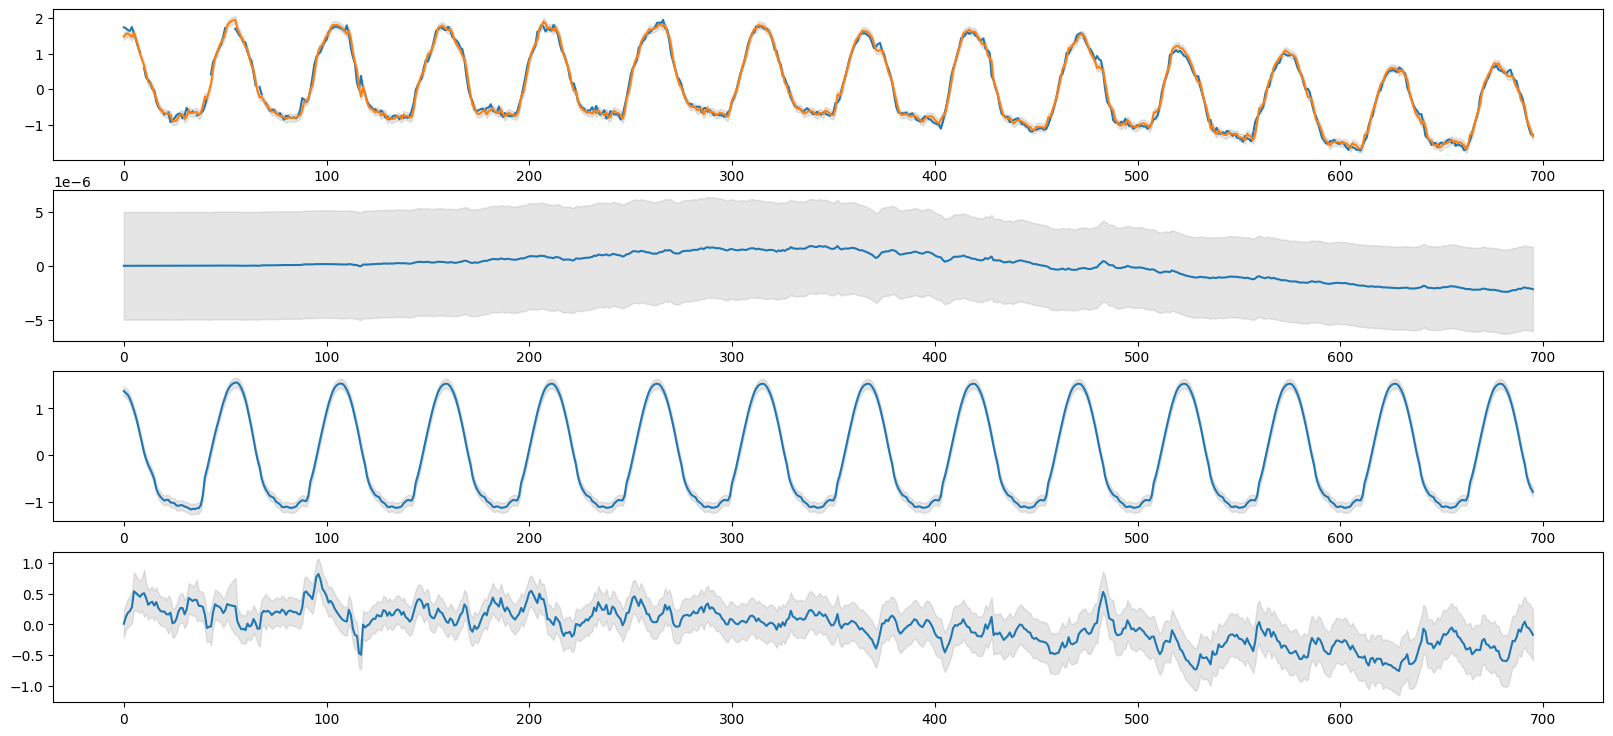

In [5]:
# Plot prediction
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(4, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

time_step_indices = np.arange(0, len(mses), 1)

# Plot prediction
ax0.plot(time_step_indices, obs_unnorm, label='Observation')
ax0.plot(time_step_indices, mu_preds_unnorm, label='Prediction')
ax0.fill_between(
    time_step_indices,
    np.array(mu_preds_unnorm).flatten() - np.sqrt(var_preds_lstm),
    np.array(mu_preds_unnorm).flatten() + np.sqrt(var_preds_lstm),
    alpha=0.2,
    color='gray',
)

# Plot AA hidden states
ax1.plot(time_step_indices, mu_aa, label='AA hidden state')
ax1.fill_between(
    time_step_indices,
    np.array(mu_aa).flatten() - np.sqrt(var_aa),
    np.array(mu_aa).flatten() + np.sqrt(var_aa),
    alpha=0.2,
    color='gray',
)

# Plot LSTM hidden states
ax2.plot(time_step_indices, mu_preds_lstm, label='LSTM hidden state')
ax2.fill_between(
    time_step_indices,
    np.array(mu_preds_lstm).flatten() - np.sqrt(var_preds_lstm),
    np.array(mu_preds_lstm).flatten() + np.sqrt(var_preds_lstm),
    alpha=0.2,
    color='gray',
)

# Plot AR hidden states
ax3.plot(time_step_indices, mu_ar, label='AR hidden state')
ax3.fill_between(
    time_step_indices,
    np.array(mu_ar).flatten() - np.sqrt(var_ar),
    np.array(mu_ar).flatten() + np.sqrt(var_ar),
    alpha=0.2,
    color='gray',
)

plt.show()